In [22]:
from boto.s3.connection import Location
from boto.s3.key import Key
from configparser import ConfigParser
from sklearn import metrics
from sklearn import svm
from sklearn.cross_validation  import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.neural_network import MLPClassifier
from statsmodels.formula.api import logit, probit, poisson, ols
import boto
import datetime
import glob
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import shutil
import statsmodels.api as sm
import time
import zipfile
import requests

In [23]:
    config = ConfigParser()

    config_file = os.path.join(os.path.dirname('__file__'), 'config.ini')
    config.read(config_file)
    default = config['user.data']
    user=default['username']
    passwd=default['password']
    trainQ=default['trainQtr']
    testQ=default['testQtr']

    print("USERNAME=" + user)
    print("PASSWORD=" + passwd)
    print("TRAINQUARTER=" + (trainQ))
    print("TESTQUARTER=" + (testQ))

USERNAME=yadav.ank@Husky.neu.edu
PASSWORD=pZF<P@U_
TRAINQUARTER=Q12005
TESTQUARTER=Q22005


In [24]:
df=pd.read_csv('trainData_' + trainQ + '.csv')
traincols=['MONTHLY_REPORTING_PERIOD','CURRENT_ACTUAL_UPB','LOAN_AGE',
           'REM_MTH_LEGAL_MATURITY','CURRENT_INTEREST_DATE','CURRENT_DEFERRED_UPB']
y_train=df['DELINQUENT']
Train_DF=df[traincols]
Train_DF.head()


,MONTHLY_REPORTING_PERIOD,CURRENT_ACTUAL_UPB,LOAN_AGE,REM_MTH_LEGAL_MATURITY,CURRENT_INTEREST_DATE,CURRENT_DEFERRED_UPB
0,200504,190000.0,0,360,5.625,0.0
1,200505,190000.0,1,359,5.625,0.0
2,200506,190000.0,2,358,5.625,0.0
3,200507,189000.0,3,357,5.625,0.0
4,200508,189000.0,4,356,5.625,0.0


In [25]:
test_df=pd.read_csv('testData_' + testQ + '.csv')
testcols = ['MONTHLY_REPORTING_PERIOD', 'CURRENT_ACTUAL_UPB', 'LOAN_AGE',
                'REM_MTH_LEGAL_MATURITY', 'CURRENT_INTEREST_DATE', 'CURRENT_DEFERRED_UPB']
y_test = test_df['DELINQUENT']
Test_DF = test_df[testcols]
Test_DF.head()

,MONTHLY_REPORTING_PERIOD,CURRENT_ACTUAL_UPB,LOAN_AGE,REM_MTH_LEGAL_MATURITY,CURRENT_INTEREST_DATE,CURRENT_DEFERRED_UPB
0,200507,214000.0,0,360,5.75,0.0
1,200508,214000.0,1,359,5.75,0.0
2,200509,214000.0,2,358,5.75,0.0
3,200510,213000.0,3,357,5.75,0.0
4,200511,213000.0,4,356,5.75,0.0


# Logistic Regression

In [7]:
model = LogisticRegression()
mod_fit = model.fit(Train_DF,y_train)

## Accuracy of Train

In [8]:
print(model.score(Train_DF,y_train))

0.9568720224673917


In [9]:
pred = mod_fit.predict(Test_DF)

## Accuracy of Test

In [10]:
metrics.accuracy_score(y_test,pred)

0.9523774930957131

## Confusion Matrix

In [11]:
print (metrics.confusion_matrix(y_test,pred))

[[28448700      179]
 [ 1422367       50]]


In [12]:
preds = model.predict_proba(Test_DF)[:,1]
fpr,tpr, _ = roc_curve(y_test,preds)

## ROC Curve

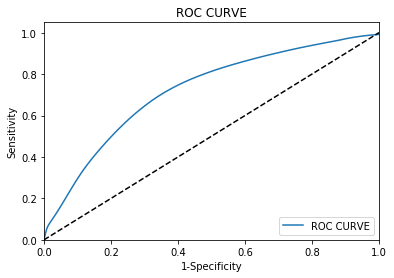

In [13]:
import matplotlib.pylab as plt

plt.figure()
plt.plot(fpr,tpr,label= "ROC CURVE")
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [15]:
logit = sm.Logit(y_train, Train_DF[traincols])
logregression_result = logit.fit()
print(logregression_result.summary())

Optimization terminated successfully.
         Current function value: 0.165377
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             DELINQUENT   No. Observations:             26508106
Model:                          Logit   Df Residuals:                 26508100
Method:                           MLE   Df Model:                            5
Date:                Thu, 29 Nov 2018   Pseudo R-squ.:                 0.06963
Time:                        13:25:38   Log-Likelihood:            -4.3838e+06
converged:                       True   LL-Null:                   -4.7119e+06
                                        LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
MONTHLY_REPORTING_PERIOD -2.979e-05   5.36e-08   -555.545      0.000   -2.99e-05

In [16]:
print(logregression_result.conf_int())

                                 0         1
MONTHLY_REPORTING_PERIOD -0.000030 -0.000030
CURRENT_ACTUAL_UPB        0.000002  0.000002
LOAN_AGE                  0.020375  0.020476
REM_MTH_LEGAL_MATURITY    0.004304  0.004356
CURRENT_INTEREST_DATE     0.032503  0.038750
CURRENT_DEFERRED_UPB     -0.000009 -0.000008


In [17]:
model.coef_

array([[-2.92169587e-05,  1.78156846e-06,  2.09367968e-02,
         4.51494852e-03, -3.67804723e-05, -1.06894916e-05]])

# Random Forest

In [26]:
clf = RandomForestClassifier(n_estimators=20,verbose =1,min_samples_split=10)
clf = clf.fit(Train_DF, y_train)

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  6.9min finished


## Train Accuracy

In [27]:
print(clf.score(Train_DF,y_train))

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   58.0s finished


0.9738744


## Test Accuracy

In [28]:
pred = clf.predict(Test_DF)

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   38.2s finished


In [29]:
metrics.accuracy_score(y_test,pred)

0.9504164

## Confusion Matrix

In [30]:
confusion_matrix(y_test, pred, labels=None, sample_weight=None)

array([[2369121,   12227],
       [ 111732,    6920]], dtype=int64)

In [31]:
preds = clf.predict_proba(Test_DF)[:,1]
fpr,tpr, _ = roc_curve(y_test,preds)

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   37.8s finished


## ROC Curve

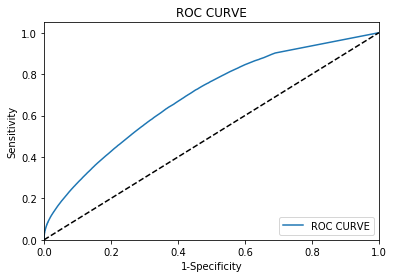

In [32]:
import matplotlib.pylab as plt

plt.figure()
plt.plot(fpr,tpr,label= "ROC CURVE")
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

# Neural Netwroks

In [33]:
clf = MLPClassifier(solver='adam', learning_rate_init=0.1,hidden_layer_sizes=(2, 4), random_state=1)
clf = clf.fit(Train_DF, y_train)

## Train Accuracy

In [34]:
pred = clf.predict(Test_DF)

In [35]:
print(clf.score(Train_DF,y_train))

0.9531212


## Test Accuracy

In [36]:
metrics.accuracy_score(y_test,pred)

0.9525392

In [37]:
pd.crosstab(y_test, pred,rownames=['pred'],colnames=['ytest'])

ytest,0
pred,
0,2381348
1,118652


In [38]:
preds = clf.predict_proba(Test_DF)[:,1]
fpr,tpr, _ = roc_curve(y_test,preds)

## ROC Curve

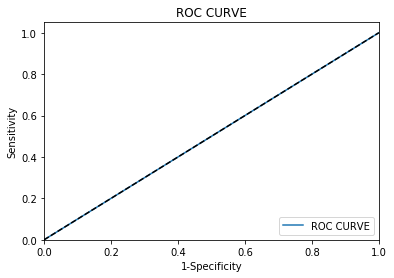

In [39]:
import matplotlib.pylab as plt

plt.figure()
plt.plot(fpr,tpr,label= "ROC CURVE")
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Confusion Matrix
Creating confusion matrix for the given quarter

In [40]:
cf=confusion_matrix(y_test, pred, labels=None, sample_weight=None)
numDelinqProper=cf[1][1]
numnondelinqimproper=cf[0][1]
numRecordsInDataset=y_test.count()
numPredictedDelinq=cf[1][0]+cf[1][1]
numActualDelinq=y_test[y_test==1].count()
    
record= testQ+","+str(numActualDelinq)+","+str(numPredictedDelinq)+","+str(numRecordsInDataset)+","+str(numDelinqProper)+","+str(numnondelinqimproper)
   

In [41]:
print(record)

Q22005,118652,118652,2500000,0,0


In [ ]:
from pathlib import Path
FINALCSVPATH= "./ClassificationMetrics.csv"
checkFile = Path(FINALCSVPATH)

if checkFile.is_file():
    with open(FINALCSVPATH,"a") as fil:
        fil.write(record)
        fil.write("\n")
else:
    with open(FINALCSVPATH,"a") as fil:
        fil.write("Quarter,NumActualDelinquents,NumOfPredictedDelinquents,NumRecordsInDataset,NumDelinquentsProperlyClassified,NumNonDelinquentsImproperlyClassified")
        fil.write("\n")
        fil.write(record)
        fil.write("\n")

## Summary
This ends our classification based on the given data.

#### Best model :
Random Forest